# TP BERT



## Introduction

Dans ce TP nous allons:
0. Comprendre comment utiliser un *Jupyter Notebook*, un outil très populaire en analyse des données
1. Préparer un jeu de données pour l’apprentissage d’un modèle BERT
3. Comprendre comment utiliser un modèle BERT pré-entraîné
4. Créer un modèle de classification en classes multiples qui exploite les représentations cachés d’un encodeur BERT
5. Entraîner ce modèle et tester ses performances

Avec les outils suivants:
1. [PyTorch](https://pytorch.org/docs/stable/index.html) : une bibliothèque Python *open-source* pour l'apprentissage machine
2. [HuggingFace’s Transformers](https://huggingface.co/transformers/) : une bibliothèque basée sur Pytorch pour le traitement automatique des langues et notamment les modèles neuronaux de type Transformer (comme BERT)
3. [HuggingFace’s Tokenizers](https://github.com/huggingface/tokenizers): une bibliothèque basée sur Pytorch pour la tokenisation, explicitement conçue pour travailler avec la bibliothèque Transformers
4. Google Colab, qui héberge ce *Jupyter Notebook*. Avant de commencer le TP, il est conseillé de consulter les pages d'introductions [à Colab](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb#scrollTo=YHI3vyhv5p85) et [aux Notebooks](https://realpython.com/jupyter-notebook-introduction/)


Les machines Colab sont livrées avec un système Linux et un environnement Python avec plusieurs bibliothèques pré-installées comme, par exemple, Pytorch. Néanmoins, si vous êtes sur une machine Colab, il faut d'abord installer les bibliothèques de HuggingFace, qui ne sont pas pré-installées.

Pour exécuter une commande Unix sur un Jupyter Notebook, il faut placer un point d’exclamation avant la commande: `!commande`. 

In [2]:
%pip install transformers tokenizers

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install torch

In [4]:
!pip install tensorboard

Maintenant nous pouvons importer les bibliothéques principales dont nous aurons besoin. 

In [5]:
import torch
import transformers

# Managing arrays
import numpy as np

# Plotting tools:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
# load the TensorBoard notebook extension
%load_ext tensorboard

**GPU**

L'apprentissage de notre réseau de neurones requiert beaucoup de calculs matriciels. Pour exécuter ces calculs plus rapidement, il est possible d'utiliser un processeur graphique (*GPU*) p. Si vous êtes sur Colab, vous pouvez utiliser un *GPU* en sélectionnant _Runtime -> Change runtime type -> GPU_.

In [6]:
if torch.cuda.is_available():
  print("GPU is available.")
  device = torch.cuda.current_device()
else:
  print("Will work on CPU.")

Will work on CPU.


### À rendre

Chaque exercice de ce TP demande une réponse sous forme textuelle ou sous forme de code. Toute réponse doit être écrite dans une ou plusieurs cellules après l’énoncé de chaque exercice.

Vous rendrez un répertoire compressé `tp_bert_nom1_nom2.zip` avec le contenu du répertoire `tp_bert.zip` dont le fichier `tp_bert.ipynb` aura été mis à jour avec vos reponses.

## Données



Nous allons entraîner notre modèle sur une tache de **classification en classes multiples**. Notamment, la tâche est celle de repartir des textes en trois catégories de sentiments:

1. négatif
2. neutre
3. positif

Ces donnés sont collectées dans le jeu de données [FinancialPhraseBank-v1.0
](https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10), que vous pouvez trouver dans le répertoire de ce TP.

Voici les informations essentielles à la compréhension de la tâche, qui figurent dans le file README.txt :

---

<em>The key arguments for the low utilization of statistical techniques in financial sentiment analysis have been the difficulty of implementation for practical applications and the lack of high quality training data for building such models. Especially in the case of finance and economic texts, annotated collections are a scarce resource and many are reserved for proprietary use only. To resolve the missing training data problem, we present a collection of ∼ 5000 sentences to establish human-annotated standards for benchmarking alternative modeling techniques. 

<em>The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.

<em>This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.

<em>Given the large number of overlapping annotations (5 to 8 annotations per sentence), there are several ways to define a majority vote based gold standard. To provide an objective comparison, we have formed 4 alternative reference datasets based on the strength of majority agreement: 

1. sentences with 100% agreement [file=Sentences_AllAgree.txt]; 
2. sentences with more than 75% agreement [file=Sentences_75Agree.txt]; 
3. sentences with more than 66% agreement [file=Sentences_66Agree.txt]; and 
4. sentences with more than 50% agreement [file=Sentences_50Agree.txt].

<em>All reference datasets are included in the release. The files are in a machine-readable "@"-separated format:

<em>**sentence@sentiment**

<em>where sentiment is either "positive, neutral or negative".

<em>E.g.,  The operating margin came down to 2.4 % from 5.7 % .@negative<em>

---

#### Exercice 1

Nous allons utiliser les phrases contenues dans _Sentences_75Agree.txt_ pour entraîner et tester notre modèle. Pour ce faire, téléchargez le fichier sur la machine Colab (utiliser l’interface à gauche) ou, si vous travaillez sur un _Jupyter Notebook_ en local, placez le fichier _Sentences_75Agree.txt_ dans le même répertoire du _Notebook_.

Ensuite, écrivez la fonction `load_data()` qui lit les phrases contenues dans ce fichier et les sépare de leurs étiquettes. Le résultat de cette fonction, assigné à la variable `data`, doit être une liste de listes, où chaque sous-liste contient une phrase comme premier élément et son étiquette comme deuxième élément. I.e.:

````
data[0][0] == 'A high court in Finland has fined seven local asphalt companies more than   lion ( $ 117 million ) for operating a cartel .'
data[0][1] == 'negative'
````

> Note: l'encodage du fichier _Sentences_75Agree.txt_ est `iso-8859-1`.

In [7]:
# WRITE FUNCTION load_data HERE

def load_data(filename,classes):
  data =[]
  file = open(filename,'r', encoding='ISO-8859-1')
  for line in file :
    temp = line.split("@")
    # temp = [sentence,annotation]
    temp[1] = temp[1][:-1]
    data.append(temp)
  return data

filename = 'Sentences_75Agree.txt'
classes = ['negative', 'neutral', 'positive']
data = load_data(filename, classes)
data

[['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'],
 ['With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
  'positive'],
 ["For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'],
 ['In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
  'positive'],
 ['Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .',
  'positive'],
 ['Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .',
  'positive'],

Testez le résultat de votre fonction en faisant tourner la cellule suivante.

In [8]:
assert type(data[0][0]) == str, "The first element of every sub-list should be a sentence."
assert data[0][1] in classes, "The second element of each sub-list should belong to one of the three classes available."
assert len(data) == 3453, "The size of data should be of 3453 sentences."
print("Test passed!")

Test passed!


Maintenant, nous allons séparer nos données pour l’entraînement et pour le test.

> NOTE: nous n'allons pas utiliser un ensemble de développement (validation) ici dans l'objective de simplifier ce TP, mais rappelé vous de l'importance du dev dans toute application réelle.

In [9]:
import random, math
from sklearn import preprocessing

# randomly sample train and test set from data
random.shuffle(data)
split = 0.85
num_elem = math.floor(len(data)*split)
train = data[:num_elem]
test = data[num_elem:]
print("Train data size : ", len(train))
print("Test data size : ", len(test))

# build input features and labels
x_train = [t[0] for t in train]
y_train = [t[1] for t in train]
x_test = [t[0] for t in test]
y_test = [t[1] for t in test]

# convert labels into integers ['negative', 'neutral', 'positive'] -> [0, 1, 2]
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

Train data size :  2935
Test data size :  518


### Baseline


#### Exercice 2

Préalablement à une tache de classification, c’est toujours une bonne idée de vérifier si les données de training et de test sont (plus ou moins) uniformément distribuées par rapport aux classes existantes.

1. Pourquoi ?

2. Quel est le nombre de données d'entraînement et de test correspondant à chaque classe ?

3. Étant donnée la distribution des étiquettes dans le _testset_, quelles sont les attentes par rapport aux performances de notre modèle en terme de _accuracy_ ? En d'autres termes, quelle est l'_accuracy_ minimale à battre par n'importe quel système de classification ? 

In [10]:
# WRITE CODE TO ANSWER THE QUESTIONS HERE,  PRINT ANSWERS OR WRITE THEM IN A TEXT CELL BELOW
def unif(input,classe):
  if classe not in classes :
    return "classe not identified"
  return 100*len([x for x in input if x[1]==classe])/len(input)

def nombre(input,classe):
  if classe not in classes :
    return "classe not identified"
  return len([x for x in input if x[1]==classe])

print("Pourcentage des classes dans le test set ")
print("negative " + str(unif(test,"negative"))+"%")
print("neutral " + str(unif(test,"neutral"))+"%")
print("positive " + str(unif(test,"positive"))+"%")
print("------------------------------------------")

print("Pourcentage des classes dans le train set ")
print("negative " + str(unif(train,"negative"))+"%")
print("neutral " + str(unif(train,"neutral"))+"%")
print("positive " + str(unif(train,"positive"))+"%")

print("------------------------------------------")

print("Nombre des classes dans le test set ")
print("negative " + str(nombre(test,"negative")))
print("neutral " + str(nombre(test,"neutral")))
print("positive " + str(nombre(test,"positive")))
print("------------------------------------------")

print("Nombre des classes dans le train set ")
print("negative " + str(nombre(train,"negative")))
print("neutral " + str(nombre(train,"neutral")))
print("positive " + str(nombre(train,"positive")))

Pourcentage des classes dans le test set 
negative 12.355212355212355%
neutral 60.23166023166023%
positive 27.413127413127413%
------------------------------------------
Pourcentage des classes dans le train set 
negative 12.12947189097104%
neutral 62.487223168654175%
positive 25.38330494037479%
------------------------------------------
Nombre des classes dans le test set 
negative 64
neutral 312
positive 142
------------------------------------------
Nombre des classes dans le train set 
negative 356
neutral 1834
positive 745


1) Ne pas vérifier que las bases de données sont uniformément distribuées peut introduire un biais dans les résultats ce qui influence négativement les résultats. <span style="color:red">-> not necessarly, an unbalanced distribution (non-uniform) would hinder the performance if the distribution in the real world is not unbalanced in the same way. If the class distribution in the data well represents the real distribution, then it is good.</span>

2) Voir le résultat ci-dessous.

3) Étant données les pourcentages, dans notre test-set, un classifieur qui ne prédit que la classe avec la plus grande occurence aura une précision de 60%. Elle sera notre précision minimale exigée.

#### Exercice 3

Dans la cellule ci-dessous, on entraîne un modèle de [classification naïve bayésienne
 en classes multiples](https://fr.wikipedia.org/wiki/Classification_na%C3%AFve_bay%C3%A9sienne), en sorte d’avoir une performance de référence. Ainsi, l’objectif dans la suite sera de faire mieux de ce naïf.

1. Pourquoi est-qu’on s’attende qu’un modèle de classification type BERT est plus puissante du modèle naïf bayésien ?
2. Dans quelles conditions les modèles non-neuronaux peuvent être plus avantageux ?

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# transform sentences in bag of words
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
x_test_counts = count_vect.transform(x_test)
# transform bag of words in tfidf vectors
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.fit_transform(x_test_counts)
# train a multinomial Naive-Bayes classifier on the tfidf vectors
classifier = MultinomialNB().fit(x_train_tfidf, y_train)
# use classifier to predict the labels of the test set
predicted = classifier.predict(x_test_tfidf)
# calculate accuracy
print("Accuracy of a simple multinomial Naive-Bayes approach :", sum(predicted == y_test)/len(predicted))

Accuracy of a simple multinomial Naive-Bayes approach : 0.7104247104247104


1. Le modèle de Bayes néglige la dépendance entre les mots contigus alors que ce n'est pas le cas pour BERT.
2. Les modèles non-neuronnaux sont plus rapides, donc on les utilisent si on a des contraintes de temps. <span style="color:red">True, but we rearly have very thight time constraints for training. We do have time constraints for inference but neural approaches like BERT are quite enough usually. The real constraints are usually: data first of all (neural models require more data than simpler ML algorithms to learn anything useful), and computational resources (neural models require a lot). </span>

## Tokenisation

La bibliothèque HuggingFace offre des outils pour faire la tokenisation des données textuelles selon les modéles que nous allons utiliser: [see the docs](https://huggingface.co/transformers/tokenizer_summary.html).

Dans ce TP, nous allons utiliser un modèles pré-entraîné qui s’appelle [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf): un encodeur avec une architecture [Transformer](https://arxiv.org/abs/1706.03762) une version distillée de BERT et qui ainsi plus léger en terme de mémoire et plus rapide. Les auteurs le présentent dans leur papier de la manière suivante :

<em>As Transfer Learning from large-scale pre-trained models becomes more prevalent in Natural Language Processing (NLP), operating these large models in on-the-edge and/or under constrained computational training or inference budgets remains challenging. In this work, we propose a method to pre-train a smaller general-purpose language representation model, called DistilBERT, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts. While most prior work investigated the use of distillation for building task-specific models, we leverage knowledge distillation during the pre-training phase and show that it is possible to reduce the size of a BERT model by 40%, while retaining 97% of its language understanding capabilities and being 60% faster. To leverage the inductive biases learned by larger models during pre-training, we introduce a triple loss combining language modeling, distillation and cosine-distance losses. Our smaller, faster and lighter model is cheaper to pre-train and we demonstrate its capabilities for on-device computations in a proof-of-concept experiment and a comparative on-device study.

In [12]:
from transformers import DistilBertTokenizer

MAX_LEN = 512

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', padding=True, truncation=True)

# let's check out how the tokenizer works
for n in range(3):
    # tokenize sentences
    tokenizer_out = tokenizer(x_train[n])
    # convert numerical tokens to alphabetical tokens
    encoded_tok = tokenizer.convert_ids_to_tokens(tokenizer_out.input_ids)
    # decode tokens back to string
    decoded = tokenizer.decode(tokenizer_out.input_ids)
    print(tokenizer_out)
    print(encoded_tok, '\n')
    print(decoded, '\n')
    print('---------------- \n')


{'input_ids': [101, 1996, 2837, 17146, 1996, 2206, 2128, 23041, 16754, 1024, 1037, 7058, 2128, 23041, 16754, 1997, 7327, 2099, 1019, 1010, 2199, 2005, 1996, 3472, 1010, 7327, 2099, 1017, 1010, 3156, 2005, 1996, 4112, 3472, 1010, 1998, 7327, 2099, 1016, 1010, 3156, 2005, 1996, 2060, 2604, 2372, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'the', 'committee', 'proposes', 'the', 'following', 're', '##mun', '##eration', ':', 'a', 'monthly', 're', '##mun', '##eration', 'of', 'eu', '##r', '5', ',', '000', 'for', 'the', 'chairman', ',', 'eu', '##r', '3', ',', '500', 'for', 'the', 'deputy', 'chairman', ',', 'and', 'eu', '##r', '2', ',', '500', 'for', 'the', 'other', 'board', 'members', '.', '[SEP]'] 

[CLS] the committee proposes the following remuneration : a monthly remuneration of eur 5, 000 for the chairman, eur 3, 500 for the deputy chairman, and eur

#### Exercice 4

1. Qu’est-ce que la sortie du tokeniseur (`tokeniser_out`) représente ? 
2. Quels sont les tokens spéciaux introduits par le tokeniseur? Quel est leur fonction?
3. Pourquoi certains tokens commencent par ## (par exemple, ##r ##oxide) ? AIDE: cherche sur Google "Byte pair encoding"
4. Notez que le tokeniseur que l'on utilise à été pré-entraîné. Pourquoi un tokeniseur comme celui-ci nécessite d’un entraînement préalable à son application ?

Réponse:
1.   le tokenize_out est un dictionnaire qui contient deux listes , une d'input ids des tokens et une autre "attention mask" qui est une liste des valeurs binaires (0 ou 1) qui fait la difference entre tokens masques(que le modele essaie de predire) et ceux non masques 
2.   Le tokeniseur ajoute un élément [CLS] au début de la phrase et un élément [SEP] à la fin. Le premier indique le début de la phrase et le deuxième est utilisé pour séparer les deux phrases d'une tache.
3. Le tokeniseur fait ça par soucis de compression. Quand il voit qu'il y'a un sous-mot qu'il a déjà vu comme token, il subdivise le mot et ajoute le double hashtag pour annoncer que c'est un sous-mot qu'il faut coller au token précèdent.
4. Il a besoin d'un entrainement préalable comme chaque intelligence artificiel pour avoir une base de mot sur laquel il doit s'appuyer pour commencer à apprendre de nouvelles choses dans la vrai vie. <span style="color:red">The tokenizer is not a NN or ML algorithm. Nonetheless, the compression algorithm (byte pair encoding) need to learn the most efficient compression on training data before applying it to other data. Here, we are applying a tokenization that was learned on the training set of the pre-trained BERT. </span> 


#### Exercise 5

BERT (et DistilBERT) gère des séquences de longueur maximale égale à 512 (`MAX_LEN=512`). Vérifier si cette longueur est optimale pour notre tâche. En d'autre termes, vérifiez quelle est la distribution des longueurs des textes que nous devons classifier et s’il serait avantageux de réduire MAX_LEN de façon à réduire le temps de traitement des séquences.

<span style="color:red">MAX_LEN refers to maximum number of tokens, not characters ! Below, you are plotting the distribution of sentence length in terms of characters instead of tokens </span>

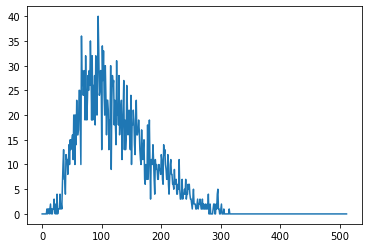

In [13]:
# WRITE CODE TO ANSWER THE QUESTION HERE.  PRINT THE ANSWER OR WRITE IT IN A TEXT CELL BELOW
distribution = [0]*512
for elem in data:
  i = len(elem[0])
  distribution[i - 1] += 1
plt.plot(distribution)

Maintenant que nous avons compris comment le tokeniseur fonctionne, nous pouvons désormais écrire une classe Dataset qui nous servira pour l'entraînement et le test. En effet, le classes Python qui s’occupent de la création de _batches_ et du training nécessitent en entrée une classe de type Dataset, comme la suivante.

**Note** changez MAX_LEN si vous avez trouvé dans l'exercice précédent quelle valeur serait plus avantageuse.

In [14]:
from torch.utils.data import Dataset, DataLoader

MAX_LEN = 320

class MyDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        # variables that are set when the class is instantiated
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)
  
    def __getitem__(self, item):
        # select the sentence and its class
        sentence = str(self.sentences[item])
        label = self.labels[item]
        # tokenize the sencence
        tokenizer_out = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
            )
        # return a dictionary with the output of the tokenizer and the label
        return  {
            'input_ids': tokenizer_out['input_ids'].flatten(),
            'attention_mask': tokenizer_out['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# instantiate two MyDataset objects
train_dataset = MyDataset(x_train, y_train, tokenizer, MAX_LEN)
test_dataset = MyDataset(x_test, y_test, tokenizer, MAX_LEN)

In [15]:
train_dataset[0]

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([  101,  1996,  2837, 17146,  1996,  2206,  2128, 23041, 16754,  1024,
          1037,  7058,  2128, 23041, 16754,  1997,  7327,  2099,  1019,  1010,
          2199,  2005,  1996,  3472,  1010,  7327,  2099,  1017,  1010,  3156,
          2005,  1996,  4112,  3472,  1010,  1998,  7327,  2099,  1016,  1010,
          3156,  2005,  1996,  2060,  2604,  2372,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## Modèle

C’est le moment de comprendre comment DistilBERT. Hugginface nous offre plusieurs modèles pré-entraînes de type DistilBERT, nous allons utiliser [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased), qui a une architecture profonde de 66’362’880 paramétres et qui a été pré-entraîné sur le jeu de données BookCorpus pour 90 heures avec huit GPUs de 16 GB de mémoire. Cela nous permettra d’obtenir de très bons résultat en attachant un classificateur très léger (un seul layer) au top de DistilBERT, qui fera le plus gros du travail, c’est-à-dire l’encodage de nos textes. Notre classificateur nécessitera d’être entraîné pendant quelques minutes seulement. 

On peut trouver les noms de tous les autres modèles pré-entraînés offerts par HuggingFace [à cette addresse](https://huggingface.co/models). 

Pour télécharger un modèle pré-entraîné on utilise l'option `.from_pretrained`:

In [16]:
from transformers import DistilBertModel

PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

distilbert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Nous pouvons encoder les séquences de textes avec une passe en avant de distilBERT, qui nous renvoie les représentations cachés de la dernière couche.

**Note** : la dimension des couches de `distilbert-base-uncased` est de 768 neurones 

**Note2** : nous utilisons la fonction `.unsqueeze(0)` parce que normalement on passe des batches au modèle, alors que cette fois ci ce n’est que un seul élement de la classe *MyDataset*. Avec `.unsqueeze(0)`, nous le traitons comme un batch de taille 1.

In [17]:
first_sent = train_dataset[0]

hidden_state = distilbert(
    input_ids=first_sent['input_ids'].unsqueeze(0), attention_mask=first_sent['attention_mask'].unsqueeze(0)
    )

hidden_state[0].shape

torch.Size([1, 320, 768])

In [18]:
distilbert.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

#### Exercice 6

Nous avons maintenant les éléments nécessaires à la construction d'un modèle de classification en classes multiples basé sur DistilBERT.

Concernant le code ci-dessous :

1. Quelle est la fonction de cet extrait de code ?
	```Python
	if freeze_encoder:
		for param in self.encoder.parameters():
			param.requires_grad = False
	```

2. Pourquoi on ne garde que la représentation caché du premier token de chaque séquence avec la commande `pooled_output = hidden_state[:, 0]` ?

3. Compléter l’extrait de code sous-jacente à `if labels is not None:` de façon à calculer la fonction de perte (*loss  function*) du modèle lorsque les cibles sont passées à la fonction `forward`



Réponses:
1. Cette extrait de code nous permet de fixer une partie de notre modèle et entraîner le reste. En effet, c'est la partie pré-entraînée qu'on gèle puisque ses paramètres sont déjà calibrés.
2. Étant donné que le BERT est bidirectionnel, le [CLS] est codé, y compris toutes les informations représentatives de tous les tokens via la procédure de codage multicouche. La représentation de [CLS] est individuelle dans différentes phrases. Le premier token peut être donc une représentation significative de la phrase entière.


In [19]:
from transformers import DistilBertPreTrainedModel, DistilBertConfig


PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
FREEZE_PRETRAINED_MODEL = True

class DistilBertForSentimentClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels, freeze_encoder=False):
        # instantiate the parent class DistilBertPreTrainedModel
        super().__init__(config)
        # instantiate num. of classes
        self.num_labels = num_labels
        # instantiate and load a pretrained DistilBERT model as encoder
        self.encoder = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # [Q1] freeze the encoder parameters if required 
        if freeze_encoder:
          for param in self.encoder.parameters():
              param.requires_grad = False
        # the classifier: a feed-forward layer attached to the encoder's head
        self.classifier = torch.nn.Linear(
            in_features=config.dim, out_features=self.num_labels, bias=True)
        # instantiate a dropout function for the classifier's input
        self.dropout = torch.nn.Dropout(p=0.1)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        # encode a batch of sequences with DistilBERT
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        # extract the hidden representations from the encoder output
        hidden_state = encoder_output[0]  # (bs, seq_len, dim)
        # only select the encoding corresponding to the first token
        # [Q2] of each sequence in the batch 
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        # apply dropout
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # feed into the classifier
        logits = self.classifier(pooled_output)  # (bs, dim)

        outputs = (logits,) + encoder_output[1:]
        
        if labels is not None:
          # [Q3] COMPLETE CODE HERE
            loss_fct = nn.CrossEntropyLoss()
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = self.classifier(hidden_state).view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1)[0], torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
        return outputs
  # (loss), logits, (hidden_states), (attentions)


# instantiate model
model = DistilBertForSentimentClassification(
    config=distilbert.config, num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
    )

# print info about model's parameters
total_params = sum(p.numel() for p in model.parameters())
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print('model total params: ', total_params)
print('model trainable params: ', trainable_params)
print('\n', model)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model total params:  66365187
model trainable params:  2307

 DistilBertForSentimentClassification(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(


## Entraînement

*Let's train our classifier!*

Le moment est arrivé. Heureusement *HuggingFace* nous fournit la classe Python nécessaire à gérer le training : `Trainer`. Nous lui passons les hyper-paramètres avec la classe `TrainingArgument`. Nous allons aussi lui passer les métrique que nous désirons pour l’évaluation du modèle en phase de test :

1. justesse (accuracy)
2. précision (precision)
3. rappel (recall)
4. f1


In [20]:
# clean logs and results directory from old files
# this could be useful if we were running the cells below multiple times
!rm -r ./logs ./results

In [21]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',          
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=50,
    num_train_epochs=16,              
    per_device_train_batch_size=8,  
    learning_rate=5e-5,
    weight_decay=0.01        
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    compute_metrics=compute_metrics
)

Pour visualiser l’évolution de la *loss* tout au long de l'entraînement, nous pouvons utiliser *TensorBoard *:

In [22]:
%tensorboard --logdir logs

In [23]:
train_results = trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2935
  Num Epochs = 16
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5872
/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None

Step,Training Loss
1,1.051300


KeyboardInterrupt: 

In [ ]:
test_results = trainer.predict(test_dataset=test_dataset)

In [ ]:
print('Predictions: \n', test_results.predictions)
#print('\nAccuracy: ', test_results.metrics['eval_accuracy'])
#print('Precision: ', test_results.metrics['eval_precision'])
#print('Recall: ', test_results.metrics['eval_recall'])
#print('F1: ', test_results.metrics['eval_f1'])
print(classes)
test_results.metrics

Si nous avons fait les choses bien, la performance (*accuracy*) de notre modèle dans la classification des phraces qu’il n’a jamais vu est d'environ 70.0%. Cela n'est pas très satisfaisant si on considère :

1. que la distribution des classes dans notre ensemble de test n’était pas équilibrée (c.f. Exercice 2)
2. qu'un modèle de classification naïve bayésienne obtient une accuracy de 72.6% (c.f. Exercice 3)
 

### Améliorer les performances

#### Exercice 7

1. Comment est-ce qu'on peut améliorer le résultat du modèle ?
2. Ré-entraînez le modèle avec la nouvelle stratégie et calculez ses performances avec les métriques utilisées avant. Quelle _accuracy_ vous arrivez à obtenir ?

**Aide** : pensez à laisser le modèle améliorer l'encodage des phrases...

1. On peut changer le learning rate , on adopte alors un learning rate de 1. 

<span style="color:red">I can't see the logs of your training but only an error. Beside changing lr, you could have tried other parameters and, most importantly, to unfreeze the encoder's parameters to finetune them on the classification task. </span>

In [ ]:
# WRITE CODE TO ANSWER THE QUESTION HERE.  PRINT THE ANSWER OR WRITE IT IN A TEXT CELL BELOW
training_args = TrainingArguments(
    output_dir='./results',          
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=50,
    num_train_epochs=16,              
    per_device_train_batch_size=8,  
    learning_rate=1e-4,
    weight_decay=0.01        
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    compute_metrics=compute_metrics
)
train_results = trainer.train()
test_results = trainer.predict(test_dataset=test_dataset)

In [ ]:
print('Predictions: \n', test_results.predictions)
test_results.metrics
print(classes)

Si nous somme satisfaits de la performance de notre modèle, nous pouvons le sauvegarder pour l’utiliser dans le prochain exercice : 

In [ ]:
MODEL_PATH = './my_model'
trainer_unfreezed.save_model(MODEL_PATH)

## Prédictions

#### Exercice 8

En utilisant le modèle que l’on vient de sauvegarder, prédire la classe à laquelle appartient les phrases suivantes :

````
  "CocaCola saw its share price dropping of more than 25% this semester.",
  "Despite most of the company's sales are taking place in China, the shareholders decided not to relocate the production there." ,
  "This year's profits quintuplicated with respect to the last year."
````

1. Quelles classes a prédit le modèle ?
2. Avec quelle probabilité ?

In [30]:
# WRITE CODE TO ANSWER THE QUESTION HERE.  PRINT THE ANSWER OR WRITE IT IN A TEXT CELL BELOW
import pandas as pd
l = ["CocaCola saw its share price dropping of more than 25% this semester.",
  "Despite most of the company's sales are taking place in China, the shareholders decided not to relocate the production there." ,
  "This year's profits quintuplicated with respect to the last year."]
data_set = pd.DataFrame(l)
test_results = trainer.predict(test_dataset=data_set)
test_results

,0
0,CocaCola saw its share price dropping of more ...
1,Despite most of the company's sales are taking...
2,This year's profits quintuplicated with respec...


## Changer de modèle

#### Exercice 9 (bonus)

Expérimentez avec d’autres modèles pré-entraînés. La liste des modèles pré-entraînés est disponible ici: https://huggingface.co/models.

- Qu’est-ce que vous avez essayé ? Laissez votre code dans des cellules ci-dessous. 
- Qu’est-ce que vous avez appris ?